In [1]:
import pandas as pd
import numpy as np
import pickle
import json
import pyspark as sc
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tensorflow.python.platform import gfile
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
# make plot outputs appear and be stored within this notebook
%matplotlib inline 

# Set figure visual attributes
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.5)

# Set figure size 
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

C:\Users\Jenario\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Set Column Header Labels
columns = ['type', 'accel x', 'accel y', 'accel z']



# Create pandas dataframe 'df' by reading in csv file or txt file in this case
df = pd.read_csv('exercises.txt', header = None, names = columns)

#df['freq'] = df['freq'].str.replace(',', '')
#df['time'] = df['time'].str.replace(' ', '')
#df["freq"] = pd.to_numeric(df["freq"])
#df.columns = [col.replace(',', '') for col in df.columns]
# this converts the module, pwr, and freq columns to ints and floats
df[['accel x', 'accel y', 'accel z']] = df[['accel x', 'accel y', 'accel z']].apply(pd.to_numeric)

#df['date'] = pd.to_datetime(df['date'], errors='coerce')
#df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S.%f')

# Remove missing values
df = df.dropna()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10786 entries, 0 to 10785
Data columns (total 4 columns):
type       10786 non-null object
accel x    10786 non-null float64
accel y    10786 non-null float64
accel z    10786 non-null float64
dtypes: float64(3), object(1)
memory usage: 421.3+ KB


In [4]:
df["type"].value_counts()

dumbbell curl                 2981
overhead triceps extension    2319
side lateral raise            2239
front lateral raise           1979
rest                          1268
Name: type, dtype: int64

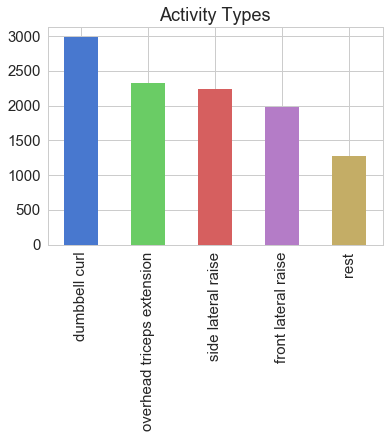

In [5]:
df['type'].value_counts().plot(kind='bar', title = 'Activity Types')

In [6]:
def plot_activity(activity, df):
    data = df[df['type'] == activity][['accel x', 'accel y', 'accel z']][:1000]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

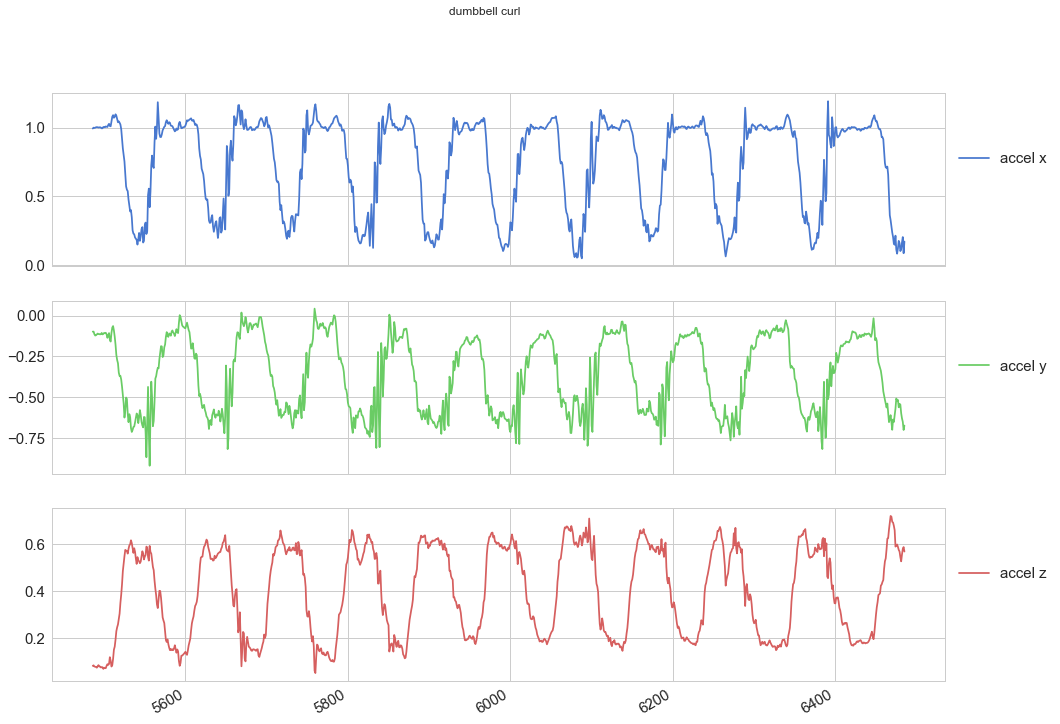

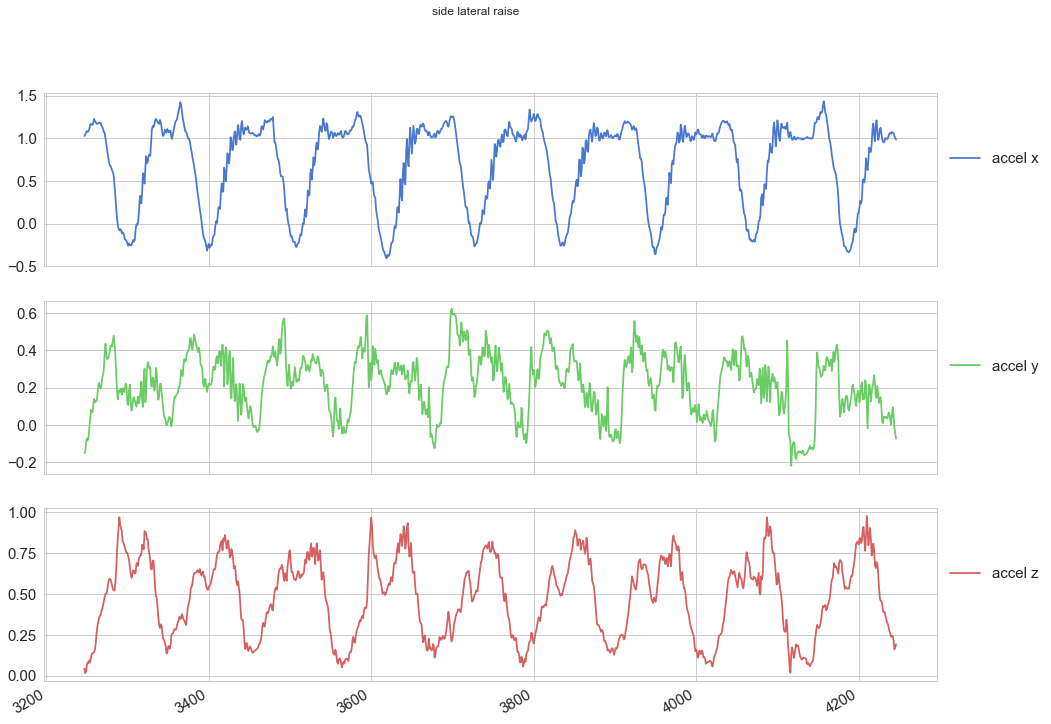

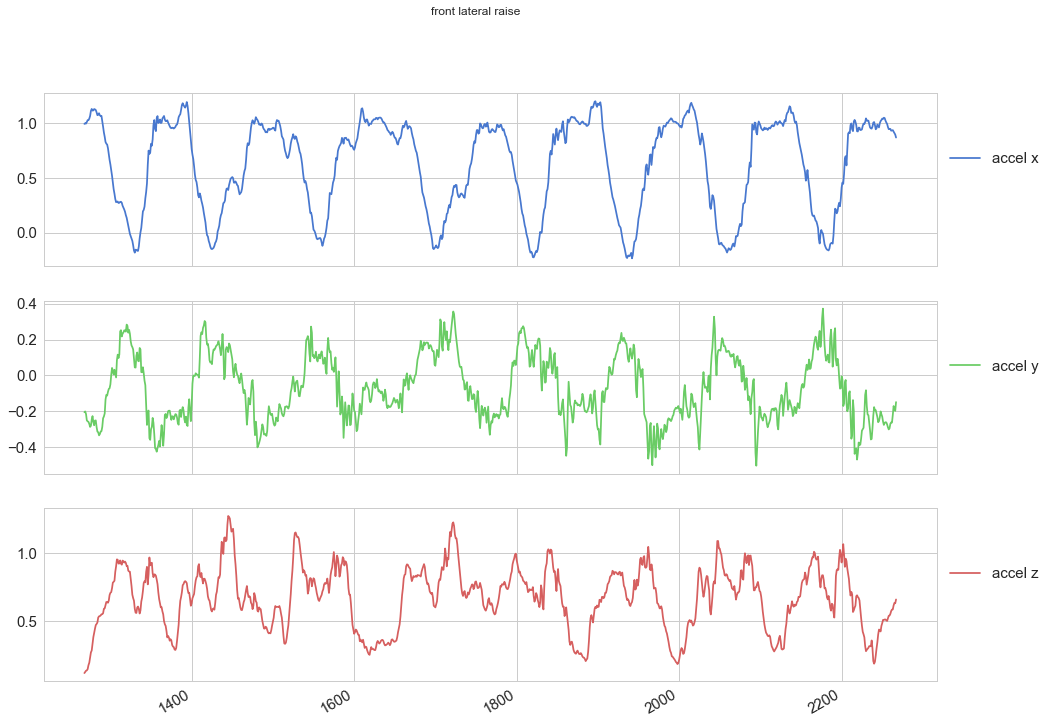

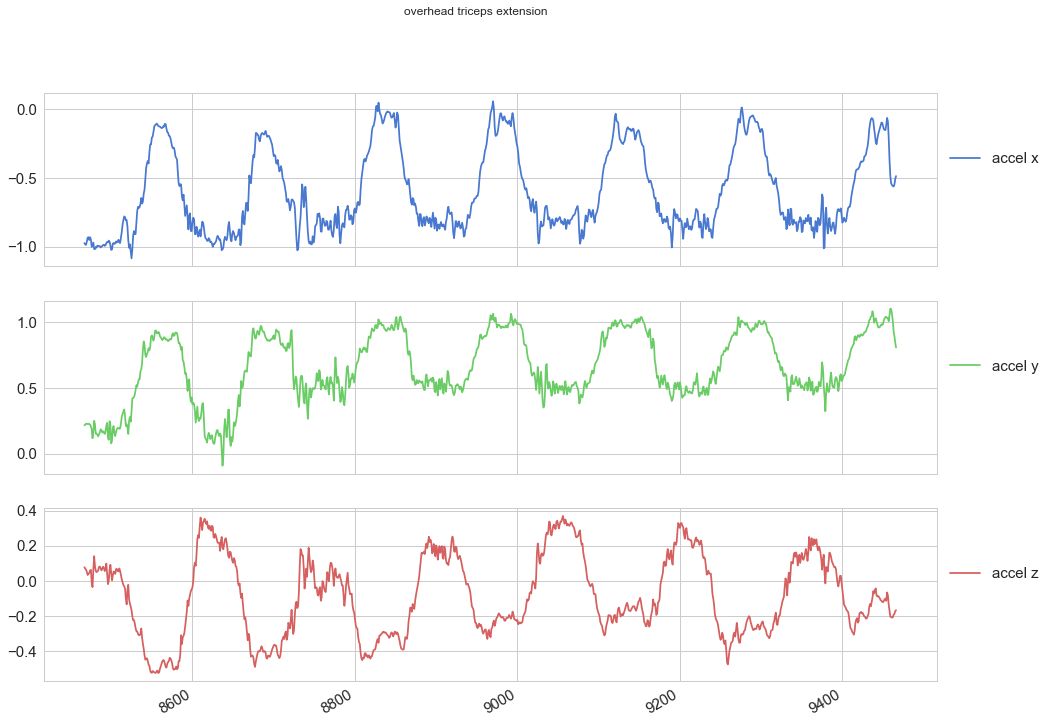

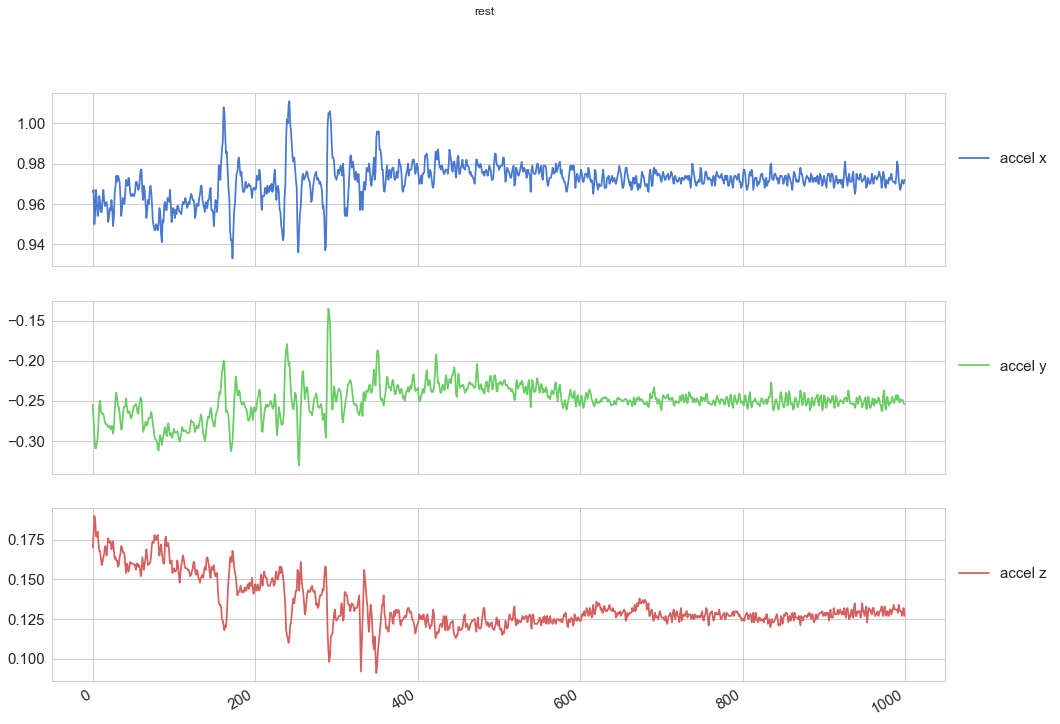

In [7]:
plot_activity("dumbbell curl", df)
plot_activity("side lateral raise", df)
plot_activity("front lateral raise", df)
plot_activity("overhead triceps extension", df)
plot_activity("rest", df)

In [8]:
N_TIME_STEPS = 200;
N_FEATURES = 3;
step = 20
segments = []
labels = []

for i in range(0, len(df) - N_TIME_STEPS, step):
    ax = df['accel x'].values[i: i + N_TIME_STEPS]
    ay = df['accel y'].values[i: i + N_TIME_STEPS]
    az = df['accel z'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['type'][i: i + N_TIME_STEPS])[0][0]
    segments.append([ax,ay,az])
    labels.append(label)

C:\Users\Jenario\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [9]:
#segments

In [10]:
np.array(segments).shape

(530, 3, 200)

In [11]:
new_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)

labels = np.asarray(pd.get_dummies(labels),dtype = np.float32)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(new_segments, labels, test_size = 0.3, random_state = RANDOM_SEED, stratify = labels)

In [13]:
N_CLASSES = 5
N_HIDDEN_UNITS = 64

In [14]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [15]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name = "input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [16]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name = "y_")

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [17]:
L2_LOSS = 0.002

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [18]:
LEARNING_RATE = 0.0005

optimizer = tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [19]:
N_EPOCHS = 40
BATCH_SIZE = 10

In [20]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.597484290599823 loss: 2.099379062652588
epoch: 10 test accuracy: 0.9496855139732361 loss: 1.0307202339172363
epoch: 20 test accuracy: 0.9056603908538818 loss: 1.0682072639465332
epoch: 30 test accuracy: 0.9874213933944702 loss: 0.646296501159668
epoch: 40 test accuracy: 0.9748427867889404 loss: 0.6575617790222168

final results: accuracy: 0.9748427867889404 loss: 0.6575617790222168


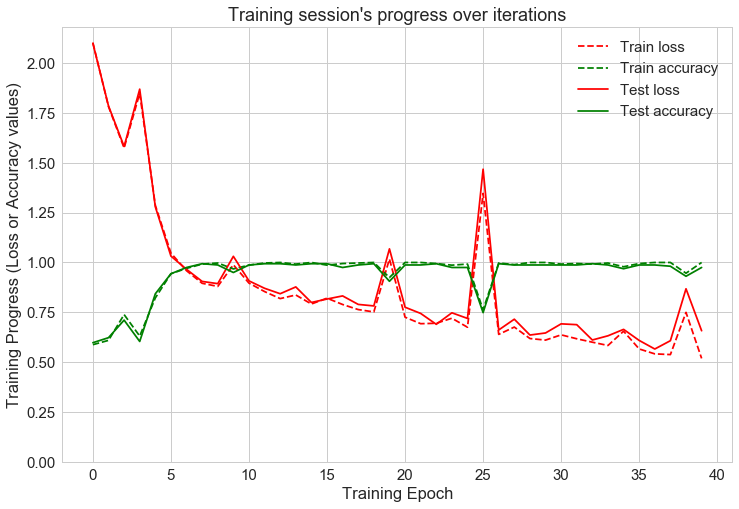

In [22]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [23]:
LABELS = ["dumbbell curl", "front lateral raise", "overhead triceps extension", "rest", "side lateral raise"]

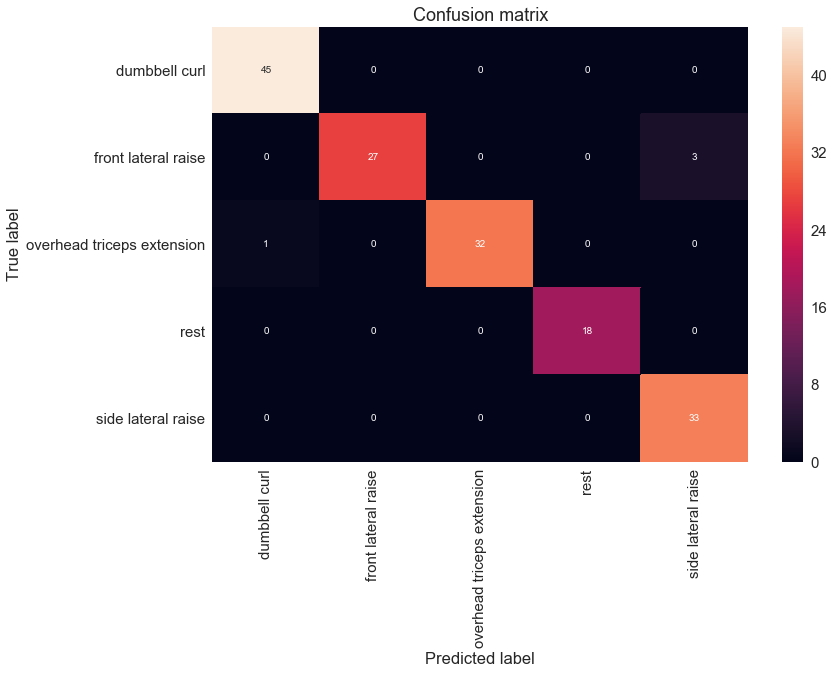

In [24]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [25]:
print(metrics.classification_report(max_test, max_predictions,target_names = LABELS))

                            precision    recall  f1-score   support

             dumbbell curl       0.98      1.00      0.99        45
       front lateral raise       1.00      0.90      0.95        30
overhead triceps extension       1.00      0.97      0.98        33
                      rest       1.00      1.00      1.00        18
        side lateral raise       0.92      1.00      0.96        33

               avg / total       0.98      0.97      0.97       159



In [27]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/exergame.pbtxt')  
saver.save(sess, save_path = "./checkpoint/exergame.ckpt")

'./checkpoint/exergame.ckpt'

In [28]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'exergame'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

INFO:tensorflow:Restoring parameters from ./checkpoint/exergame.ckpt
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


In [ ]:
tensorflow$ bazel run tensorflow/contrib/lite/toco:toco -- \
--input_file=[...]/save/rnn_frozen.pb \
--input_format=TENSORFLOW_GRAPHDEF \
--output_format=TFLITE \
--output_file=[...]/save/rnn_frozen.tflite \
--input_arrays="Placeholder" \
--input_shapes=1,28,28 \
--output_arrays="output" \
--allow_custom_ops